---
title : Multi-Armed Bandits with Haskell / hbandit tutorial
---

This page serves as a tutorial for the [`hbandit`](https://github.com/freuk/hbandit) multi-armed bandit (MAB) haskell module. It only briefly covers the setting and does not discuss the algorithms themselves. For the purpose of learning about bandits, I would suggest reading @bubeck2012regret. 

The snippets in this page contain simulation, analysis and plotting code to compare the experimental behavior of the regret of various algorithms from the library. The page only covers non-contextual algorithms.  

# Setup

The code snippets on this page [^source] require the following list of extensions and modules.

[^source]: [Here is the source for this page in `ipynb` notebook format.](./hbandit.ipynb)

In [1]:
{-# language LambdaCase FlexibleContexts DeriveGeneric OverloadedStrings #-}
{-# language ViewPatterns OverloadedLists OverloadedLabels DataKinds #-}
{-# language FlexibleInstances ScopedTypeVariables StandaloneDeriving #-}
{-# language NoImplicitPrelude TemplateHaskell DeriveAnyClass # -}
{-# language RecordWildCards QuasiQuotes ParallelListComp RankNTypes #-}

In [2]:
import Protolude
import Bandit
import Bandit.EpsGreedy
import Bandit.Exp3
import Bandit.UCB

More modules will be loaded later in this page.

# The (non-contextual) bandit game
The basic bandit game is the following:

For $r \in {1,\ldots,T}$  
  $\quad$ Nature selects losses $\ell_{a}^r \in \mathbb{L} \quad \forall a \in \mathbb{A}$  
  $\quad$ The algorithm chooses action $a^r \in \mathbb{A}$  
  $\quad$ The algorithm observes loss $\ell_{a^r}^r \in \mathbb{L}$.  
		
We use the notation $r$ to denote bandit rounds. Here is some general purpose code used to simulate this process. A game state keeps the history of actions and losses, along with the current bandit state:

In [3]:
import qualified Data.List.NonEmpty as NonEmpty
import System.Random
import qualified Data.Sequence as Sequence

data GameState b a l
  = GameState
      { historyActions :: NonEmpty.NonEmpty a,
        historyLosses :: Sequence.Seq l,
        bandit :: b,
        stdGen :: StdGen
      }
  deriving (Generic, Show)

For the purposes of simulation, we will write iteration of the game as a value in the corresponding state monad parametrized on an adversary behavior of type `a->l` :

In [4]:
import Control.Lens
import Data.Generics.Labels
import Statistics.Sample

iteration :: (Show b, Bandit b hyper a l) =>
    ( a -> l ) -> 
    StateT (GameState b a l) Identity ()
iteration actionToLoss = do
    (actionToLoss . NonEmpty.head -> loss) <- use #historyActions
    oldGen <- use #stdGen
    (action, newGen) <- zoom #bandit $ step oldGen loss
    #stdGen .= newGen
    #historyActions %= (action NonEmpty.<|)
    #historyLosses %= (loss Sequence.<|)

The `onePass` function takes an hyperparameter, an oblivious deterministic adversary of type `[a->l]`, an initial standard generator and returns the simulation result.

In [5]:
onePass ::
    forall b hyper a l . (Show b, Bandit b hyper a l) => 
    hyper ->
    StdGen -> 
    [a -> l] -> 
    GameState b a l
onePass hyper g adversaries = runGame adversaries 
    (initialGame initialAction initialBanditState g')
 where initialBanditState :: b
       (initialBanditState, initialAction, g') = Bandit.init g hyper
       
runGame adversaries = execState (game adversaries)
game adversaries = for_ adversaries iteration
initialGame ia ib g =  GameState
    { historyActions = [ia],
      historyLosses = [],
      bandit = ib,
      stdGen = g
    }

As an example, we can specialize this to the `EpsGreedy` datatype on a small toy dataset, using a fixed rate:

In [6]:
let gs :: GameState (EpsGreedy Bool FixedRate) Bool Double
    gs = onePass 
            EpsGreedyHyper { rateRep = FixedRate 0.5,
                             arms = Bandit.Arms [True, False]
                           }
            (mkStdGen 1) 
            [ \case True -> a; False -> b
              | a <- [40, 2, 10] 
              | b <- [4, 44 ,3]
            ]
 in putText $
  "Action series: " <>  show  (historyActions gs ^.. traversed) <>
  "\nLoss series: " <>  show (historyLosses gs ^.. traversed)

Action series: [True,True,False,True]
Loss series: [10.0,44.0,40.0]

# Generating synthetic arms

We generate gaussian arms in the following way.

In [63]:
import Data.Random.Distribution
import Data.Random
import Refined hiding (NonEmpty)
import Refined.Unsafe

generateGaussianData ::
  Int ->                -- ^ number of rounds
  [ZeroOne Double] ->   -- ^ arm averages
  IO [[Double]]         -- ^ dataset
generateGaussianData (fromIntegral -> n :: Double) avgs = 
    mapM generate (unrefine <$> avgs )
  where
    generate :: (MonadRandom m) => Double -> m [Double]
    generate mu = forM [1..n] $ const $ sample (rvar (Normal mu (sqrt 0.05)))

dataset <- generateGaussianData 400 (unsafeRefine <$> [0.2, 0.5, 0.8])

Let's compute some summary statistics and plot that data.

In [64]:
import Graphics.Rendering.Chart.Renderable
import Graphics.Rendering.Chart.Backend.Cairo as BC
import Graphics.Rendering.Chart
import Graphics.Rendering.Chart.Plot
import IHaskell.Display

In [65]:
import qualified Data.ByteString.Char8 as Char
import Data.Default.Class

displaySize w h renderable = do
    pngDisp <- chartData w h renderable BC.PNG
    svgDisp <- chartData w h renderable BC.SVG
    return $ Display [pngDisp, svgDisp]
chartData :: Width -> Height -> Renderable a -> FileFormat -> IO DisplayData
chartData width height  renderable format = do
  switchToTmpDir
  let filename = ".ihaskell-chart.png"
      opts = def { _fo_format = format, _fo_size = (width, height) }
  renderableToFile opts filename renderable
  imgData <- Char.readFile filename
  return $
    case format of
      BC.PNG -> png width height $ base64 imgData
      BC.SVG -> svg $ Char.unpack imgData

In [66]:
import qualified Data.Vector.Generic as V
import qualified Data.Vector as Ve

summarizeArms :: [[Double]] -> [(Double, Double, Double)]
summarizeArms arms = [
    (fromInteger . toInteger $ i, 
    mean (V.fromList a :: Ve.Vector Double),
    stdDev (V.fromList a ::Ve.Vector Double)) 
    | a <- arms | i <- [1 .. (length arms)]]

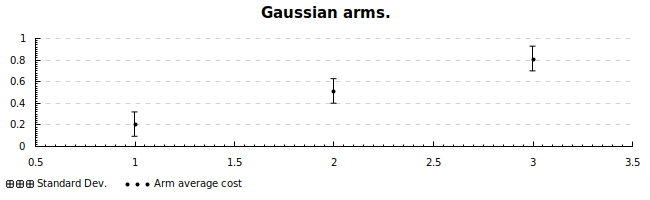

In [69]:
import Data.Default.Class
import Data.Colour
import Data.Colour.Names

armbars dataset title = toRenderable layout
  where
    vals = summarizeArms dataset
    bars = plot_errbars_line_style . line_color .~ opaque black
         $ plot_errbars_values .~ [symErrPoint x y 0 (std/2) 
                                  | (x,y,std) <- vals]
         $ plot_errbars_title .~"Standard Dev."
         $ def
    points = plot_points_style .~ filledCircles 2 (opaque black)
           $ plot_points_values .~ [(x,y) | (x,y,dx) <- vals]
           $ plot_points_title .~ "Arm average cost"
           $ def
    hidden = PlotHidden 
        [ 0.9, (fromIntegral . length $ dataset) + 0.5] 
        [ 0 ,0 ]
    layout = layout_title .~ title
           $ layout_x_axis . laxis_override .~ axisGridHide
           $ layout_plots .~ [toPlot bars, toPlot points, toPlot hidden]
           $ def
           
displaySize 650 200$ toRenderable (armbars dataset "Gaussian arms.")

Many bandit algorithms require rewards/costs to be in the $\left[ 0,1 \right]$ range, so let's apply a threshold on that data.

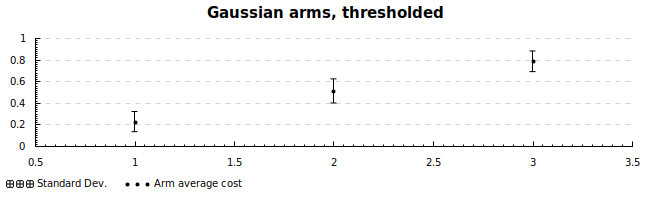

In [70]:
shoveDataset ::  [[Double]] -> [[ZeroOne Double]]
shoveDataset = (fmap.fmap) shove01

shove01 :: Double -> ZeroOne Double
shove01 x
    | x < 0 = Bandit.zero
    | x > 1 = Bandit.one
    | otherwise = unsafeRefine x

shoved = shoveDataset dataset

displaySize 650 200 $ toRenderable $
    armbars ((fmap.fmap) unrefine shoved) 
        "Gaussian arms, thresholded"

This helper converts this dataset to the `[action->loss]` oblivious deterministic adversary format.

In [71]:
toAdversary :: [[a]] -> [Int -> a]
toAdversary xss = Protolude.transpose xss <&> listToAdversary
 where
  listToAdversary :: [a] -> Int -> a
  listToAdversary l i = l ^?! ix i

# Running example experiments
We define some experiments:

In [84]:
exp3 :: 
    [[Double]] ->
    StdGen ->
    GameState (Exp3 Int) Int (ZeroOne Double)
exp3 dataset g = 
  onePass 
      (Bandit.Arms [0..2]) 
      g (toAdversary $ shoveDataset dataset)
                 
greedy :: 
    (Rate r, Show r) => 
    [[Double]] -> 
    StdGen -> r -> 
    GameState (EpsGreedy Int r) Int Double
greedy dataset g r =  
  onePass 
      EpsGreedyHyper {
          rateRep = r,
          arms = Bandit.Arms [0..2]
          }
      g (toAdversary dataset)

ucb1sim :: 
    [[Double]] -> 
    StdGen  -> 
    GameState (UCB Int AlphaUCBInvLFPhi) Int (ZeroOne Double)
ucb1sim dataset g  =  
  onePass (hyperAlphaUCB 0.5 $ Bandit.Arms [0..2]) g 
      (toAdversary $ shoveDataset dataset)

We generate multiple datasets and run those experiments. 

In [73]:
data SimResult t v =
  SimResult {
    t :: t Int,
    seed :: t Int,
    greedy05 :: t v,
    ucb1 :: t v,
    greedysqrt05 :: t v,
    exp3pf :: t v
  } deriving (Generic)
  
simulation :: Int -> Int -> IO (SimResult [] Double)
simulation tmax seed@(mkStdGen -> g) = do
  dataset <- (fmap.fmap) unrefine . shoveDataset <$> 
      generateGaussianData tmax (unsafeRefine <$> [0.2, 0.5, 0.8])
  return $ 
    SimResult {
        t = [1 .. tmax],
        seed = Protolude.replicate tmax seed,
        greedy05 = extract $ greedy dataset g (FixedRate 0.5),
        ucb1 = fmap unrefine . extract $ ucb1sim dataset g,
        greedysqrt05 = extract $ greedy dataset g (InverseSqrtRate 0.5),
        exp3pf = fmap unrefine . extract $ exp3 dataset g
    }
 where
   extract = Protolude.toList . Sequence.reverse . historyLosses

We next run this experiment with an array of random seeds:

In [74]:
results :: [SimResult [] Double] <- forM ([1..20] ::[Int]) (simulation 100)    

# Regret plot

Typed data analysis in Haskell is overkill for a one-off analysis, but I feel it is still more pleasant to read than `Frames`-based code or R, so that's what the following few snippet do. We need a datatype for holding the analysis results:

In [75]:
-- | Statistics over a set of K time series x^(k)_t until time T
data StatsTS = 
    StatsTS {
        averageTS :: Double,  -- | avg(x^(k)_t)     over k = 1..K 
        stdDevTS :: Double,   -- | std.dev(x^(k)_t) over k = 1..K 
        minTS :: Double,      -- | max(x^(k)_t)      for k = 1..K 
        maxTS :: Double       -- | max(x^(k)_t)      for k = 1..K 
    }

data ExpeResult t =
    ExpeResult {
          tr            :: t Int,
          greedy05r     :: t StatsTS,
          ucb1r         :: t StatsTS,
          greedysqrt05r :: t StatsTS,
          exp3pfr       :: t StatsTS
      } deriving (Generic)

The `summarizeExperiments` function computes those statistics. This is in my opinion the only inconvenient part of this page, due to the need to manually transpose data around for processing. 

In [76]:
summarizeExperiments :: [SimResult [] Double] -> ExpeResult []
summarizeExperiments resultList = ExpeResult {
            tr = t (resultList ^?! ix 1),
            greedy05r     = toStatsTS greedy05,
            ucb1r         = toStatsTS ucb1,
            greedysqrt05r = toStatsTS greedysqrt05,
            exp3pfr       = toStatsTS exp3pf
        }
  where
    expesToStats accessor = mkStats <$> transpose (accessor <$> resultList)
    toStatsTS accessor = mkStats <$> transpose 
        (resultList <&> 
            \(accessor -> ts) -> 
                [ sum (take k ts) - fromIntegral k * 0.2
                | k <- [1.. length ts]
                ]
        )
    mkStats xs = StatsTS {
        averageTS = mean $ Ve.fromList xs,
        stdDevTS = stdDev $ Ve.fromList xs,
        minTS = minimum xs,
        maxTS = maximum xs
    }

Remains to build some accessors for plotting.

In [77]:
import Control.Arrow

mkTS :: (StatsTS -> a) -> 
        ExpeResult [] -> 
        (ExpeResult [] -> [StatsTS]) ->
        [(Int,a)]
mkTS viewer er accessor = [ (t,viewer x) | t <- tr er | x <- accessor er ]

getCumulativeTS            = mkTS averageTS
getCumulativeMinMaxTS      = mkTS (minTS &&& maxTS)
getCumulativeUpperStdBound = mkTS $ \x -> averageTS x + stdDevTS x / 2.0
getCumulativeLowerStdBound = mkTS $ \x -> averageTS x - stdDevTS x / 2.0

Here is the regret plot for various algorithms, along with standard deviation (dashed lines) and best/worst experiment (coloured span). 

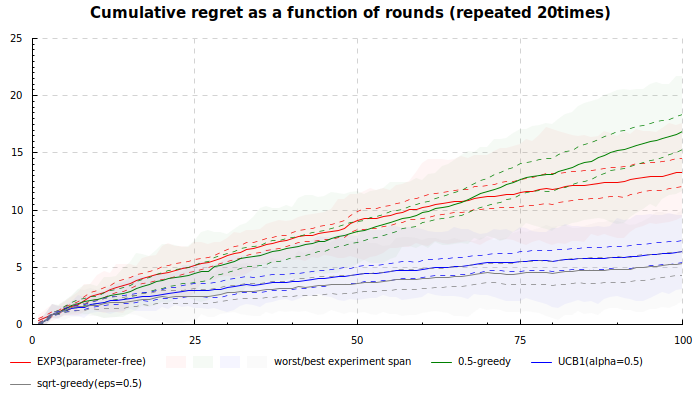

In [87]:
compareSimulations :: Int -> ExpeResult [] -> Layout Int Double 
compareSimulations repetitions er = layout
  where
    area ts col = plot_fillbetween_style  .~ 
        solidFillStyle (withOpacity col 0.04)
           $ plot_fillbetween_values .~ ts
           $ plot_fillbetween_title  .~ "worst/best experiment span"
           $ def
    value ts col name = plot_lines_style . line_color .~ opaque col
           $ plot_lines_values .~ [ts]
           $ plot_lines_title .~ name
           $ def
    dashed ts col = plot_lines_values .~ [ts]
           $ plot_lines_style .~ dashedLine 0.7 [5,5] (withOpacity col 1)
           
           $ def
    fullCurve :: 
        (ExpeResult [] -> [StatsTS]) -> Colour Double ->
        IHaskellPrelude.String -> [Plot Int Double]
    fullCurve accessor col name = [
        toPlot $ value  (getCumulativeTS er accessor)            col name,
        toPlot $ area   (getCumulativeMinMaxTS er accessor)      col,
        toPlot $ dashed (getCumulativeUpperStdBound er accessor) col,
        toPlot $ dashed (getCumulativeLowerStdBound er accessor) col
        ]
    oneCurve :: 
        (ExpeResult [] -> [StatsTS]) -> Colour Double ->
        IHaskellPrelude.String -> [Plot Int Double]
    oneCurve accessor col name = 
        [toPlot (value (getCumulativeTS er accessor) col name)]
    layout = layout_title .~
                "Cumulative regret as a function of rounds (repeated "
                <> show repetitions <> "times)"
           $ layout_y_axis . laxis_generate .~ scaledAxis def (0,22)
           $ layout_plots .~  
                   fullCurve exp3pfr       red   "EXP3(parameter-free)"
                <> fullCurve greedy05r     green "0.5-greedy" 
                <> fullCurve ucb1r         blue  "UCB1(alpha=0.5)"
                <> fullCurve greedysqrt05r gray  "sqrt-greedy(eps=0.5)"
           $ def
           
displaySize 700 400 $ toRenderable $ 
    compareSimulations 20 $ summarizeExperiments results